# Functions

Load model and data

In [8]:
from collections import OrderedDict
# from scipy import misc
# from imageio import imsave
import torch
import cv2
from data.cocostuff_loader import *
from data.vg import *
from model.resnet_generator_v2 import *
from utils.util import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from data.datasets import get_dataset, get_num_classes_and_objects
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import Resize
from typing import Union
from utils.depth import get_depth_layout


@dataclass
class MyArgs:
    dataset: str = ''
    model_path: str = ''
    model_depth_path: str = ''
    sample_path: str = ''


def load_model(path, net):
    if not os.path.isfile(args.model_path):
        print('Model not found')
        raise FileNotFoundError('Model not found')

    state_dict = torch.load(path)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`nvidia
        new_state_dict[name] = v

    model_dict = net.state_dict()
    pretrained_dict = {k: v for k,
                       v in new_state_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    net.load_state_dict(model_dict)

    net.cuda()
    net.eval()

    return net


args = MyArgs()
args.dataset = 'clevr-occs'
# args.model_depth_path = 'outputs/coco-depth-latent/G_55.pth'
args.model_depth_path = './outputs/clevr-occs-depth-latent-2xEpochs/G_400.pth'
# args.model_path = 'outputs/coco-baseline/G_65.pth'
args.model_path = 'outputs/clevr-occs-baseline-2xEpochs/G_400.pth'
use_both = True

num_classes, num_o = get_num_classes_and_objects(args.dataset)

dataset = get_dataset(args.dataset, 128, 'val',
                      num_obj=num_o,
                      return_filenames=True, return_depth=True)

if args.dataset == 'coco':
    idx2name = dataset.vocab['object_idx_to_name']
elif args.dataset == 'clevr' or args.dataset == 'clevr-occs':
    idx2name = dataset.idx2label
elif args.dataset == 'vg':
    idx2name = dataset.vocab

if dataset.return_depth:
    netG = ResnetGeneratorDepth128(
        num_classes=num_classes, output_dim=3).cuda()
    netG = load_model(args.model_depth_path, netG)

    if use_both:
        netG_normal = ResnetGenerator128(
            num_classes=num_classes, output_dim=3).cuda()
        netG_normal = load_model(args.model_path, netG_normal)
else:
    netG = ResnetGenerator128(num_classes=num_classes, output_dim=3).cuda()
    netG = load_model(args.model_path, netG)


# if not os.path.exists(args.sample_path):
#     os.makedirs(args.sample_path)
thres = 2.0


Functions

In [2]:
def draw_bboxes(image: torch.Tensor, bbox: Union[torch.Tensor, np.ndarray], labels: torch.Tensor, text=True, color_transform=None, show_idx=False):
    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    colors = None
    label_str = None

    # scale boxes to image size
    # boxes with xmax and ymax
    coord_boxes = scale_boxes(
        bbox, image.shape[-2:], 'coordinates', dtype=torch.int)

    if color_transform is not None:
        # all non-transformed bboxes will be white
        colors = [(255, 255, 255) for _ in range(len(labels))]

        # color transformed bboxes in red
        for i in color_transform:
            colors[i] = (255, 0, 0)

    # show object row index in the tensor
    if show_idx:
        label_str = [str(i) for i in range(len(labels))]

    # show textual label
    if text:
        if show_idx:
            # show both text and objects' indices
            label_str = [label_str[i]+'-'+idx2name[labels[i]]
                         for i in range(len(labels))]
        else:
            label_str = [idx2name[l] for l in labels]

    # draw bboxes
    image = draw_bounding_boxes(
        image, coord_boxes, labels=label_str, colors=colors)

    return image


In [3]:
def experiment(variable, num_gen=23, max_cols=6, figsize=(20, 13), skip=0, transform_bbox=None, transform=None, show_idx=False, show_labels=True):

    fakes = []

    # fixed inputs
    if not 'layout' in variable:
        if dataset.return_depth:
            _, label, bbox, depth, *_ = dataset[skip]
        else:
            _, label, bbox, *_ = dataset[skip]

        if isinstance(bbox, np.ndarray):
            bbox = torch.from_numpy(bbox)
        # label, bbox = label.long().unsqueeze(-1).cuda(), torch.from_numpy(bbox)

        # display bounding boxes on a black tensor
        layout = torch.zeros(3, 128, 128).type(torch.uint8)
        if transform_bbox is not None:
            # color transformed bboxes in red
            layout = draw_bboxes(
                layout, bbox, label, color_transform=transform_bbox, show_idx=show_idx, text=show_labels)
        else:
            layout = draw_bboxes(layout, bbox, label,
                                 show_idx=show_idx, text=show_labels)

        fakes.append(layout.permute(1, 2, 0))

    if not 'z_obj' in variable:
        z_obj = torch.from_numpy(truncted_random(
            num_o=num_o, thres=thres)).float().cuda()
    if not 'z_img' in variable:
        z_im = torch.from_numpy(truncted_random(
            num_o=1, thres=thres)).view(1, -1).float().cuda()

    # varying inputs
    for idx in range(num_gen):
        # get new layout at each iteration
        if 'layout' in variable:
            if dataset.return_depth:
                _, label, bbox, depth, *_ = dataset[skip+idx]
            else:
                _, label, bbox, *_ = dataset[skip+idx]

            if isinstance(bbox, np.ndarray):
                bbox = torch.from_numpy(bbox)

            # display bounding boxes on a black tensor
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox, label, show_idx=show_idx)
            fakes.append(layout.permute(1, 2, 0))

        bbox_cp = bbox.clone()

        if not transform_bbox is None and idx > 0:
            # apply random transformation to some boxes
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                if transform is None:
                    bbox_cp[box_i] = torch.tensor(
                        [xl+random.uniform(-0.5, 0.5), yl+random.uniform(-0.5, 0.5), w*random.uniform(0, 2), h*random.uniform(0, 2)])
                else:
                    bbox_cp = transform(box_i, idx, bbox_cp)

            # display bounding boxes on a black tensor, coloring the transformed ones in red
            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(
                layout, bbox_cp, label, color_transform=transform_bbox, show_idx=show_idx)
            fakes.append(layout.permute(1, 2, 0))

        # sample new noise vectors at each iteration
        if 'z_obj' in variable:
            z_obj = torch.from_numpy(truncted_random(
                num_o=num_o, thres=thres)).float().cuda()
        if 'z_img' in variable:
            z_im = torch.from_numpy(truncted_random(
                num_o=1, thres=thres)).view(1, -1).float().cuda()

        if dataset.return_depth:
            fake_images = netG.forward(z_obj, bbox_cp.cuda().unsqueeze(
                0), z_im=z_im, y=label.long().cuda(), depths=depth.cuda())
        else:
            fake_images = netG.forward(
                z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        # normalize from [-1,1] to [0,1]
        fakes.append(fake_images.detach().squeeze().permute(
            1, 2, 0).cpu() * 0.5 + 0.5)

    # put all images in a plot grid
    n_rows = int(math.ceil((len(fakes))/6))
    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in enumerate(fakes):
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)


In [4]:
def sample_one(idx=None, show_labels=False):

    # if no image is specified, select a random one
    idx = int(np.ceil(np.random.random()*len(dataset))-1) if idx is None else idx
    print(f'Image: {idx}')

    # control plot order and size
    if dataset.return_depth:
        cols, ax_id, figsize = (
            3, 0, (9, 3)) if args.dataset == 'coco' else (2, 0, (6, 3))
    else:
        cols, ax_id, figsize = (1, 0, (3, 3))

    _, axs = plt.subplots(1, cols, figsize=figsize)

    if dataset.return_depth:
        if args.dataset == 'coco':
            real, _, bbox, depth, filename, flip = dataset[idx]
        else:
            real, _, bbox, depth = dataset[idx]

        print([(i, d) for i, d in enumerate(depth)])

        if isinstance(bbox, np.ndarray):
            bbox = torch.from_numpy(bbox)

        if args.dataset == 'coco':
            resize_ = Resize(dataset.image_size)

            # load depthmap
            depthmap = torch.from_numpy(
                np.load(Path(dataset.depth_dir, filename + '.npy')))
            depthmap = resize_(depthmap.unsqueeze(0))
            depthmap = depthmap.squeeze()

            if flip:
                # flip the depthmap as the image is also flipped
                depthmap = torch.fliplr(depthmap)

            axs[ax_id].imshow(depthmap, cmap='gray')
            ax_id += 1

        # get depth layout
        depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)

        axs[ax_id].imshow(depth_layout, cmap='gray')
        ax_id += 1
    else:
        real, _, bbox, *_ = dataset[idx]

        if isinstance(bbox, np.ndarray):
            bbox = torch.from_numpy(bbox)

    coord_box = scale_boxes(
        bbox, dataset.image_size, 'coordinates', dtype=torch.int)

    # from [-1,1] to [0,255]
    real = ((real.cpu() + 1) / 2 * 255).type(torch.uint8)
    # draw boxes
    real = draw_bounding_boxes(real, coord_box)

    if dataset.return_depth:
        axs[ax_id].imshow(real.permute(1, 2, 0))
    else:
        axs.imshow(real.permute(1, 2, 0))

    experiment([], 1, 2, figsize=(6, 3), skip=idx,
               show_idx=True, show_labels=show_labels)


In [5]:
layout_index = 29


# Experiments with latents
Fixed layout, everything else varies

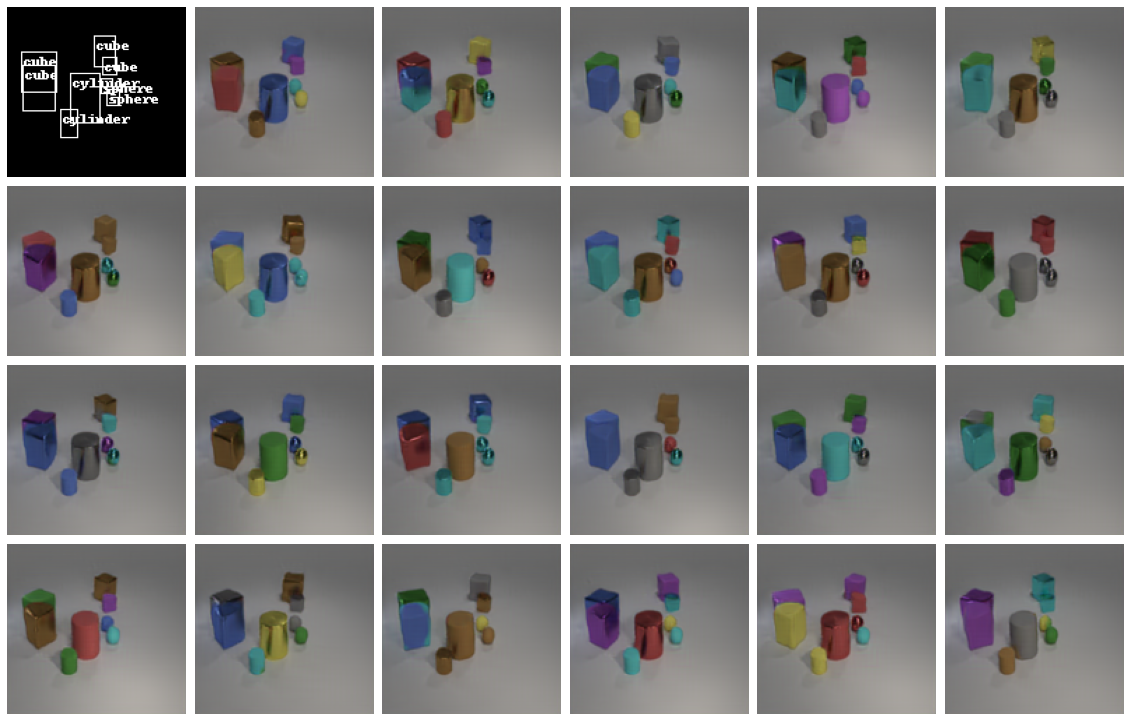

In [7]:
experiment(['z_img', 'z_obj'], skip=layout_index)


Only vary image appearance

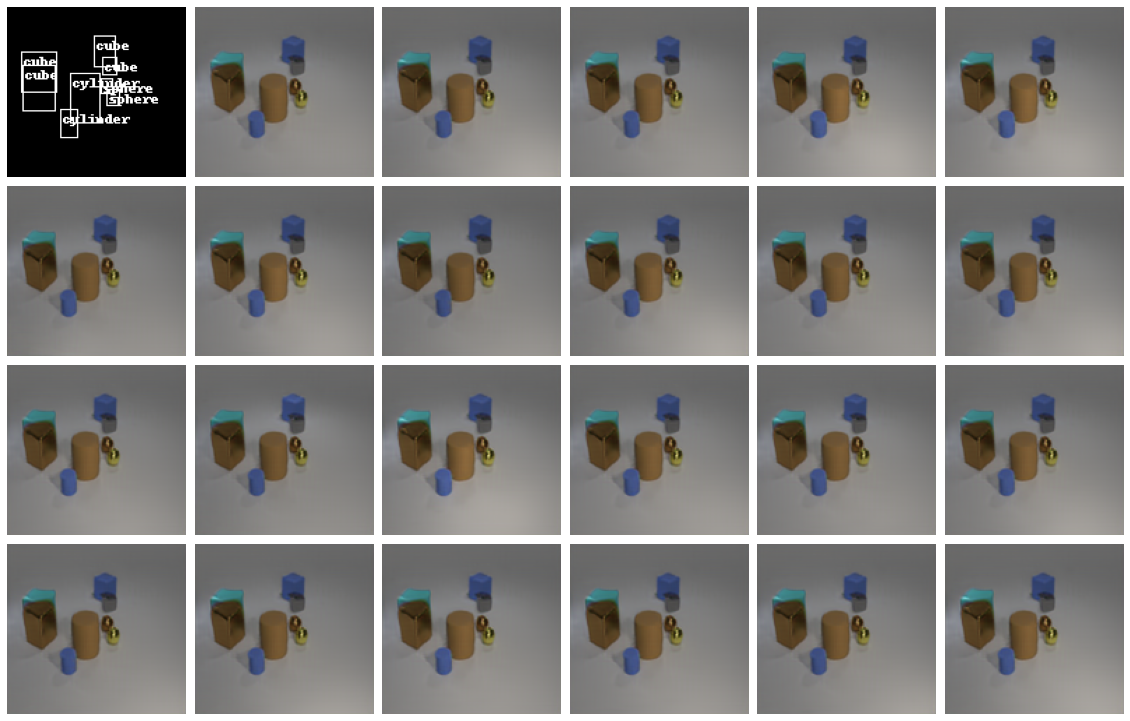

In [8]:
experiment(['z_img'], skip=layout_index)


Vary object appearances

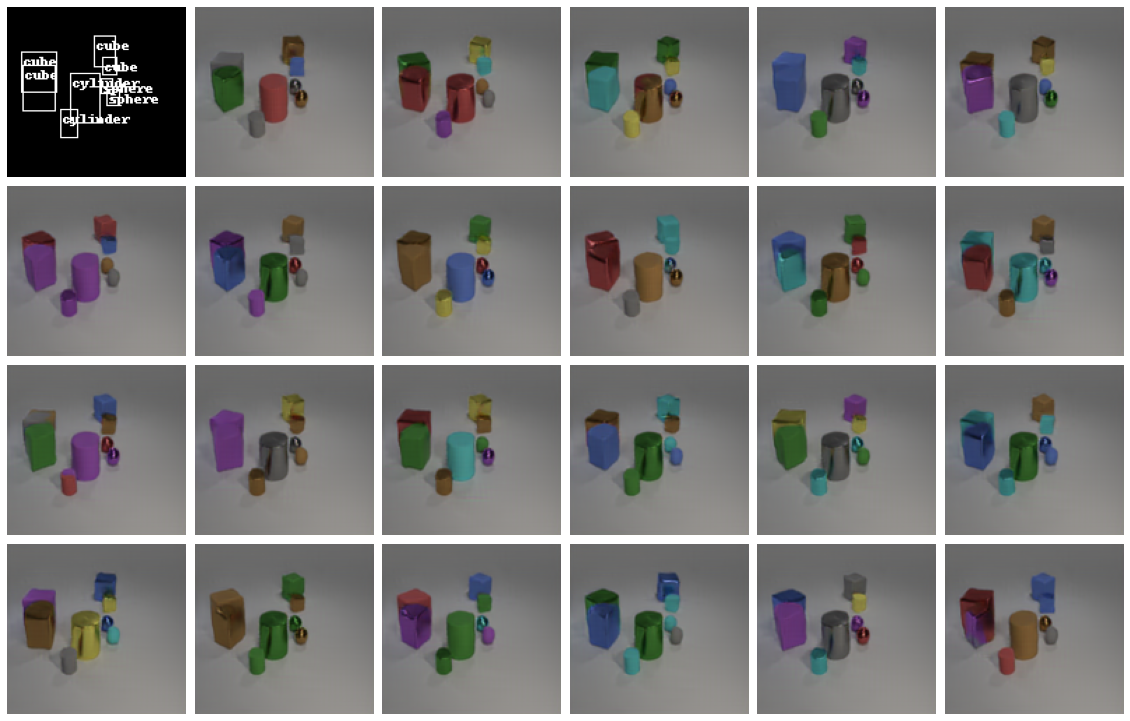

In [9]:
experiment(['z_obj'], skip=layout_index)


Vary layout

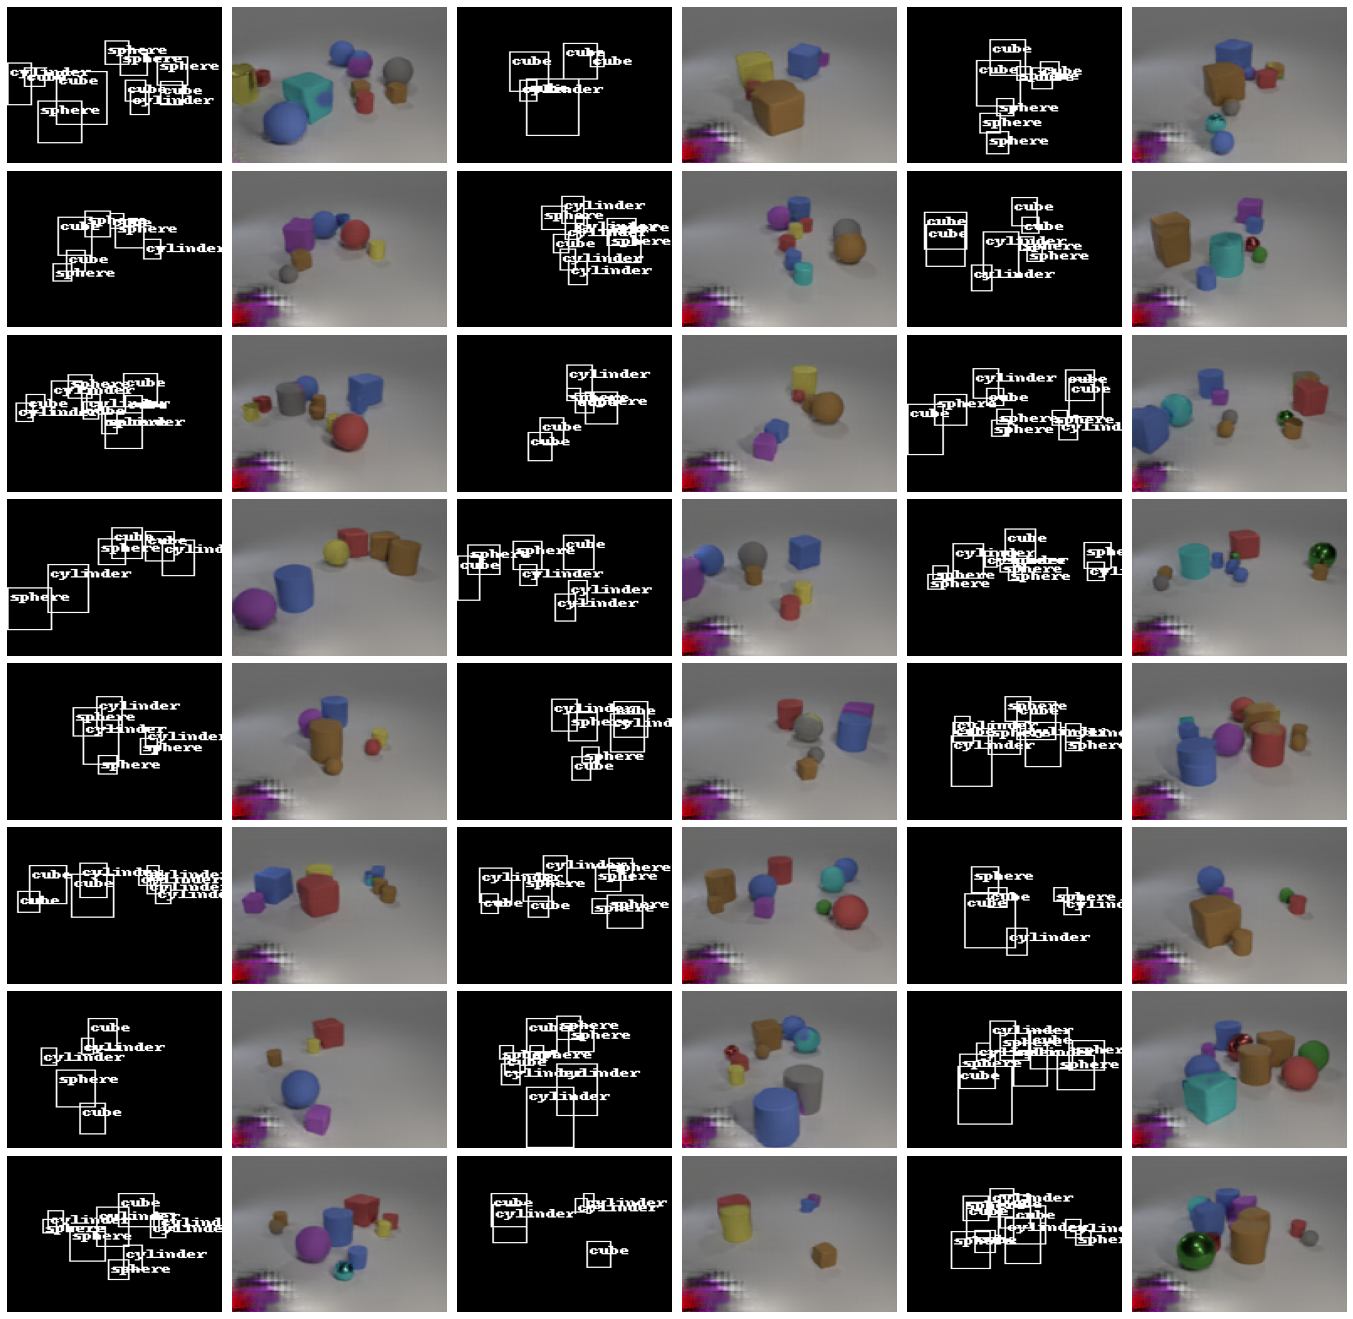

In [10]:
experiment(['layout'], figsize=(24, 24), num_gen=24, skip=24)


# Experiments with bounding boxes
Transform bounding boxes

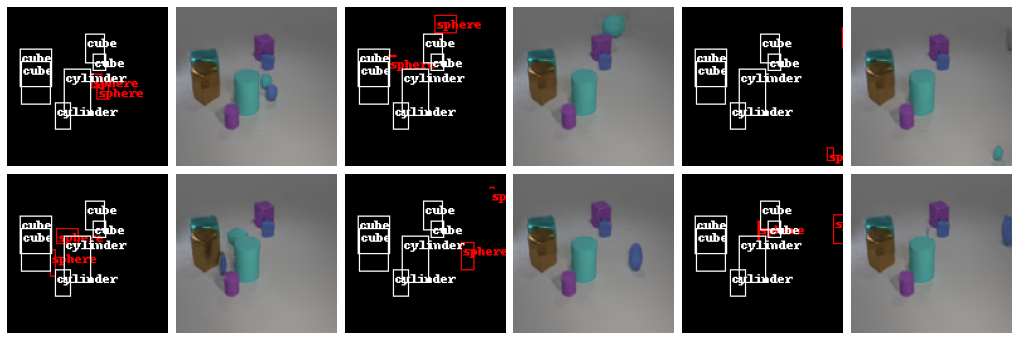

In [12]:
experiment([], figsize=(18, 6), num_gen=6,
           skip=layout_index, transform_bbox=[0, 1])


Remove bboxes by moving them outside of the scene and making them very small

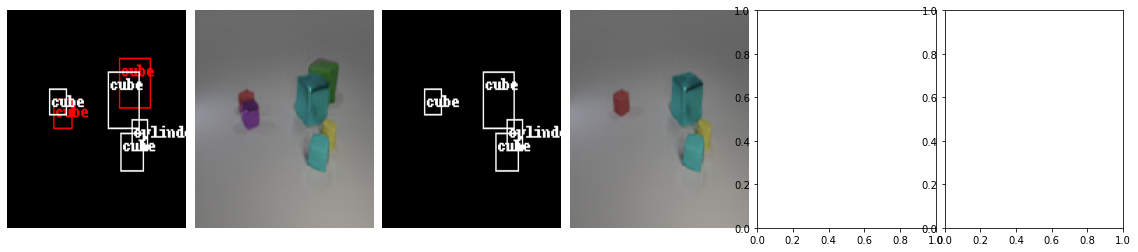

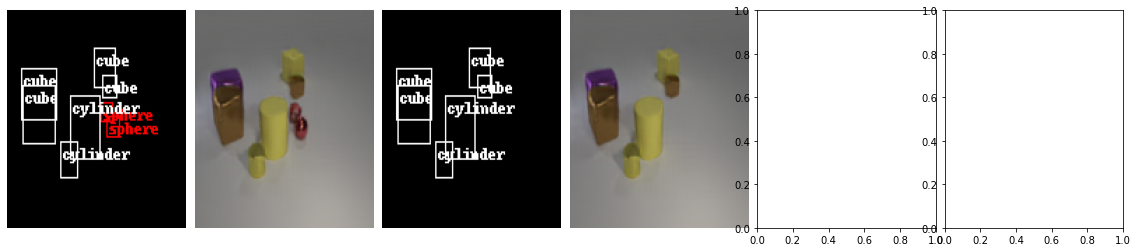

In [13]:
def remove_bbox(box_i, idx, bbox):
    bbox[box_i] = torch.tensor([-0.1, -0.1, 0.0001, 0.0001])
    return bbox


# COCO
# 29
# 4 clouds, 5 sea
# 0, 1 boats
# 23
# 4 sky-other
# 0 grass
experiment([], figsize=(20, 4), num_gen=2, skip=23,
           transform_bbox=[4, 0], transform=remove_bbox)
# experiment([], figsize=(20, 4), num_gen=2, skip=29, transform_bbox=[4,5], transform=remove_bbox)
experiment([], figsize=(20, 4), num_gen=2, skip=29,
           transform_bbox=[0, 1], transform=remove_bbox)


# Experiments with videos

In [13]:
def experiment_video(num_gen=23, max_cols=6, figsize=(20, 13), skip=0, transform_bbox=None, transform=None, pixels=1, vid_name=None, max_plot=None, use_both=False):

    fakes = []

    z_obj = torch.from_numpy(truncted_random(
        num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(
        num_o=1, thres=thres)).view(1, -1).float().cuda()

    for idx in range(num_gen):

        if idx == 0:
            if dataset.return_depth:
                _, label, bbox, depth, *_ = dataset[skip]
            else:
                _, label, bbox, *_ = dataset[skip]

            if isinstance(bbox, np.ndarray):
                bbox = torch.from_numpy(bbox)

            layout = torch.zeros(3, 128, 128).type(torch.uint8)
            layout = draw_bboxes(layout, bbox, label)
            fakes.append(layout.permute(1, 2, 0))
            bbox_cp = bbox.clone()

        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[box_i]

                if transform is None:
                    # slightly move to the right
                    bbox_cp[box_i] = torch.tensor(
                        [xl+pixels*(1/128), yl, w, h])
                else:
                    bbox_cp = transform(box_i, idx, pixels, bbox_cp)

        if dataset.return_depth:
            fake_images = netG.forward(z_obj, bbox_cp.cuda().unsqueeze(
                0), z_im=z_im, y=label.long().cuda(), depths=depth.cuda())

            if use_both:
                fake_images_normal = netG_normal.forward(
                    z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

                # normal on top, depth on bottom
                fake_images = torch.cat(
                    (fake_images_normal, fake_images), dim=2)
        else:
            fake_images = netG.forward(
                z_obj, bbox_cp.cuda().unsqueeze(0), z_im, label.long().cuda())

        # fakes.append(fake_images.detach().squeeze().permute(1,2,0).cpu() * 0.5 + 0.5)
        # normalize from [-1,1] to [0,255]
        fakes.append(((fake_images.detach().squeeze().permute(
            1, 2, 0).cpu() + 1) / 2 * 255).type(torch.uint8).numpy().astype(np.uint8))

    h, w, c = fakes[1].shape
    filename = f'samples/vids/{args.dataset}_{vid_name}_{skip}.avi'

    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    writer = cv2.VideoWriter(filename, fourcc, 10, (w, h))

    for frame in fakes[1:]:
        # normalize image to be converted to uint8
        # frame = cv2.normalize(src=frame.numpy(), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        writer.write(frame)

    writer.release()

    # plot max_plot frames in a grid
    if max_plot is None:
        end_for = enumerate(fakes)
        n_rows = int(math.ceil((len(fakes))/6))
    else:
        end_for = enumerate(fakes[:max_plot])
        n_rows = int(math.ceil(max_plot / 6))

    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in end_for:
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)


Moving objects

Image: 359
[(0, tensor(0.7820)), (1, tensor(1.)), (2, tensor(0.3954)), (3, tensor(0.5700)), (4, tensor(0.6954)), (5, tensor(0.4920)), (6, tensor(0.)), (7, tensor(0.1362)), (8, tensor(0.5806)), (9, tensor(-0.5000))]


/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/andrea/miniforge3/envs/lost2/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


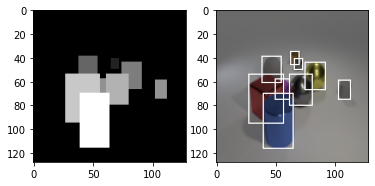

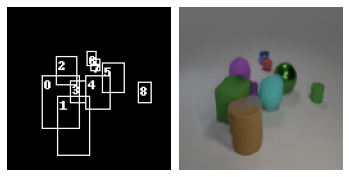

In [15]:
sample_one()

In [6]:
def move_down(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl+pixels*(1/128), w, h])
    return bbox


def move_up(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl, yl-pixels*(1/128), w, h])
    return bbox


def move_left(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl-pixels*(1/128), yl, w, h])
    return bbox


def move_right(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    bbox[box_i] = torch.tensor([xl+pixels*(1/128), yl, w, h])
    return bbox


def move_left_bigger(box_i, idx, pixels, bbox):
    xl, yl, w, h = bbox[box_i]
    dh = 60/128 if idx == 0 else 0
    bbox[box_i] = torch.tensor([xl-pixels*(1/128), yl, w, h+dh])
    return bbox


def right_diag(box_i, idx, pixels, bbox):
    bbox = move_up(box_i, idx, pixels, bbox)
    bbox = move_right(box_i, idx, pixels, bbox)
    return bbox


# experiment_video(use_both=use_both, figsize=(15, 10), num_gen=120, skip=14682, transform_bbox=[1], transform=move_left, vid_name='', max_plot=24)


# Experiments with depth

In [6]:
def experiment_depth_clevr(idx, frames=2, transform_idx=None, transform=None, figsized=None, both=False, transform_args=None):

    if not dataset.return_depth:
        return

    # control plot order and size
    rows, cols, figsize = frames, 2, (12, 6)
    figsized = (9, 9) if figsized is None else figsized

    _, axs = plt.subplots(1, (3 if both else 2), figsize=figsize)
    _, axsd = plt.subplots(rows, cols, figsize=figsized)

    real, label, bbox, depth = dataset[idx]

    if isinstance(bbox, np.ndarray):
        bbox = torch.from_numpy(bbox)

    #### DISPLAY ORIGINAL ###

    # get depth layout
    depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)

    axs[0].imshow(depth_layout, cmap='gray')
    axs[0].set_title('Original depth layout')

    coord_box = scale_boxes(
        bbox, dataset.image_size, 'coordinates', dtype=torch.int)

    # from [-1,1] to [0,255]
    real = ((real.cpu() + 1) / 2 * 255).type(torch.uint8)
    # draw boxes
    real = draw_bounding_boxes(real, coord_box)

    axs[1].imshow(real.permute(1, 2, 0))
    axs[1].set_title('Real image')

    # sample new noise vectors at each iteration
    z_obj = torch.from_numpy(truncted_random(
        num_o=num_o, thres=thres)).float().cuda()
    z_im = torch.from_numpy(truncted_random(
        num_o=1, thres=thres)).view(1, -1).float().cuda()

    # generate fake
    if both:
        fake = netG_normal.forward(z_obj, bbox.clone().cuda().unsqueeze(
            0), z_im, label.long().cuda()).squeeze()
        axs[2].imshow(fake.detach().permute(1, 2, 0).cpu()*0.5+0.5)
        axs[2].set_title('Fake image')

    #### TRANSFORM AND GENERATE ####

    for t in range(frames):
        if transform_idx is not None and transform is not None:
            for box_i in transform_idx:
                if transform_args is None:
                    bbox, depth = transform(box_i, t, bbox, depth)
                else:
                    bbox, depth = transform(box_i, t, bbox, depth, *transform_args)

        # t = 0 -> unmodified fake

        # new depth layout
        depth_layout = get_depth_layout(depth, real.shape[-2:], bbox)
        axsd[t, 0].imshow(depth_layout, cmap='gray')
        if t == 0:
            axsd[t, 0].set_title(f'Original depth layout')
        else:
            axsd[t, 0].set_title(f'Modified depth layout {t}')

        # new fake
        fake = netG.forward(z_obj, bbox.clone().cuda().unsqueeze(
            0), z_im=z_im, y=label.long().cuda(), depths=depth.cuda()).squeeze()
        axsd[t, 1].imshow(fake.detach().permute(1, 2, 0).cpu()*0.5+0.5)
        axsd[t, 1].set_title(f'Depth-aware fake {t+1}')

        print(f'Fake {t+1} depths: {[(i, d) for i, d in enumerate(depth)]}')


Fake 1 depths: [(0, tensor(0.8525)), (1, tensor(1.)), (2, tensor(0.4267)), (3, tensor(0.5614)), (4, tensor(0.7271)), (5, tensor(0.5033)), (6, tensor(0.1660)), (7, tensor(0.)), (8, tensor(0.2428)), (9, tensor(0.3868))]
Fake 2 depths: [(0, tensor(0.8525)), (1, tensor(1.)), (2, tensor(0.4267)), (3, tensor(0.5614)), (4, tensor(0.5033)), (5, tensor(0.7271)), (6, tensor(0.1660)), (7, tensor(0.)), (8, tensor(0.2428)), (9, tensor(0.3868))]


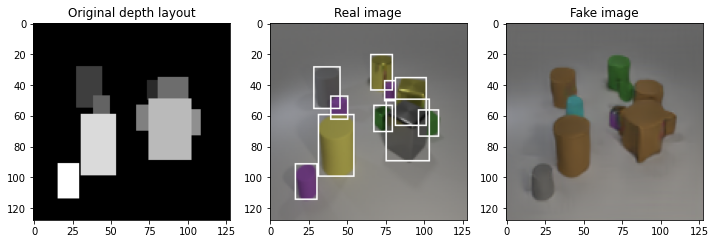

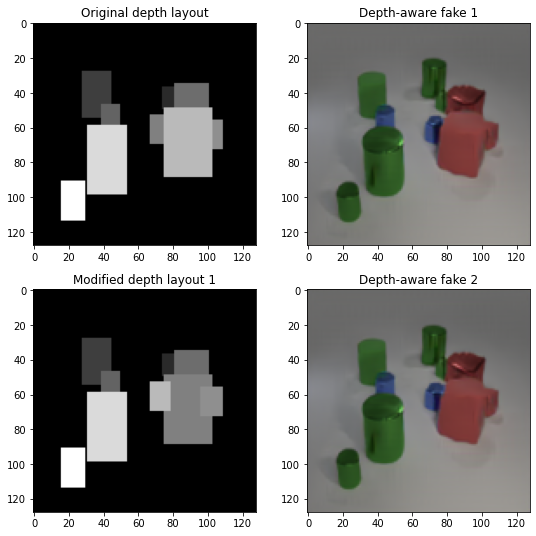

In [11]:
def transform(box_i, t, bbox, depth, a, b):
    if t > 0:
        tmp = depth[a].clone()
        depth[a] = depth[b].clone()
        depth[b] = tmp

    return bbox, depth


# experiment_depth_clevr(830, transform_idx=[0], transform=transform, both=use_both, transform_args=(4,5))
experiment_depth_clevr(154, transform_idx=[0], transform=transform, both=use_both, transform_args=(4,5))
# experiment_depth_clevr(416, transform_idx=[0], transform=transform, both=use_both, transform_args=(3,2))
# experiment_depth_clevr(216, transform_idx=[0], transform=transform, both=use_both, transform_args=(3,2))